In [7]:
import sys
from pathlib import Path
import typing as t
from langgraph.graph import StateGraph, START, END

sys.path.append(str(Path().cwd().parent))

from llm_experiments.chat import instantiate_chat

In [25]:
class State(t.TypedDict):
    query: str
    first_answer: str
    is_a_fact: bool
    summarized_answer: str

In [14]:
model = instantiate_chat("4o-mini")

In [46]:
def generate_first_answer(state: State):
    msg = model.invoke(f"answer question: {state['query']}")
    return {"first_answer": msg.content}

def fact_check(state: State):
    msg = model.invoke(f"do a fact check on the following answer: {state['first_answer']}\n. answer only with true or false")
    return {"is_a_fact": msg.content}

def check_if_answer_is_a_fact(state: State):
    if state["is_a_fact"]:
        return "true"
    else:
        return "false"

def summarize_answer(state: State):
    msg = model.invoke(f"summarize the answer: {state['first_answer']}")
    return {"summarized_answer": msg.content}

graph = StateGraph(State)
graph.add_node("generate_first_answer", generate_first_answer)
graph.add_node("fact_check", fact_check)
graph.add_node("summarize_answer", summarize_answer)

graph.add_edge(START, "generate_first_answer")
graph.add_edge("generate_first_answer", "fact_check")
graph.add_conditional_edges("fact_check", check_if_answer_is_a_fact, {"true": "summarize_answer", "false": END})
graph.add_edge("summarize_answer", END)

chain = graph.compile()

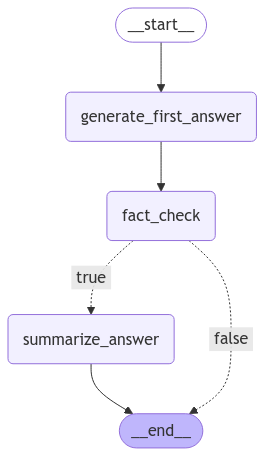

In [47]:
from IPython.display import display
from IPython.display import Image

display(Image(chain.get_graph().draw_mermaid_png()))

In [48]:
from pprint import pprint

pprint(chain.invoke({"query": "who is the president of the united states?"}))

{'first_answer': 'As of my last knowledge update in October 2023, the '
                 'President of the United States is Joe Biden. He took office '
                 'on January 20, 2021. Please verify with up-to-date sources, '
                 'as situations may have changed since then.',
 'is_a_fact': 'True',
 'query': 'who is the president of the united states?',
 'summarized_answer': 'As of October 2023, Joe Biden is the President of the '
                      'United States, having taken office on January 20, 2021. '
                      'Verify with current sources for any updates.'}
